## CS166 Location-Based Project: Traffic Intersections

Goal: use modeling and simulation to compare the traffic engineering strategies to optimize traffic flow in a particular section of the city

Think about what the city's needs are and how you to best address the needs
Modeling assumptions
How you arrived at the results
Interpretation of the results
Conclusions

In [1]:
# metric: average traffic flow at each time step

In [314]:
import numpy as np
import heapq
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import random
from tqdm import tqdm
from collections import deque
from operator import itemgetter

In [454]:
class Car:
    """
    we need the vehicle class because the cars have possibilities to 
    turn left / right / go straight at each of the intersections. 
    It would be easier to track and model their microscopic behavior 
    in this simulation and calculate the macroscopic characteristics
    attributes
    """
    
    def __init__(self, speed, road_index, direction = 's'):
        self.speed = speed
        self.road_index = road_index
        self.direction = direction
        
        
    def add_speed(self, size):
        self.speed += size
        
    def set_speed(self, new_speed):
        self.speed = new_speed
    

In [516]:
class TrafficLight:
    """
    we need the traffic light class to store the attributes for each traffic light and provide 
    methods to update the value of the traffic light.
    """
    def __init__(self, exit_road, enter_road, intersection_index, time = 20):
        # corresponding intersection
        self.intersection_index = intersection_index
        # length of the traffic light
        self.time = time
        
        self.exit_road = exit_road
        self.enter_road = enter_road
        
    def set_time(self, time):
        self.time = time
        
    def increase_time(self, time):
        self.time *= (1 + 0.1 * time)
        
    def decrease_time(self, time):
        self.time *= (1 - 0.1 * time)

In [517]:
# while the traffic light is on, let the corresponding road move and update
# 

In [518]:
class Road:
    '''
    we need the road class to store the attributes for each road and provide 
    methods to update the state of the road

    a queue is used to track the vehicles currently on each road 
    the first car in the queue is the car that entered the road first 
    and therefore should leave the road first, if we assume that there's 
    no take over happening in between
    
    '''
    def __init__(self, index, road_length, car_density, max_speed, prob_slow, tl = -1, next_s = -1, next_r = -1, 
                 next_l = -1, arrival_distribution = None, turn_prob = (1, 0, 0)):
        self.index = index
        self.next_s = next_s
        self.next_r = next_r
        self.next_l = next_l
        
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        # how much probability to 
            # go straight
            # go left
            # go right
            # adding up to 1
        self.turn_prob = turn_prob
        
        # Create an empty road based on length and density
        # -1 means empty in this simulation
        self.state = [-1 for i in range(self.road_length)]
        # choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length), 
            size = int(round(car_density * self.road_length)),
            replace = False)
        # create car object in selected locations
        # with initial speed from 0 to max_speed
        for index in random_indexes:
            speed = np.random.randint(1, self.max_speed + 1)
            direction = random.choices(['s', 'l', 'r'], weights=self.turn_prob)
            car = Car(speed, self.index, direction)
            self.state[index] = car
            
        self.average_traffic_flow = []
        self.has_prev = False
        # store the exited cars from the previous street 
        self.next_arrival = deque([])
        self.arrival_distribution = arrival_distribution
        self.num_inward = 0
        self.tl = tl
        
    def move(self):
        # update the state of the road in each timestep
        
        # update current car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:
                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i].speed < self.max_speed:
                    self.state[i].add_speed(1)
                # Deceleration
                if self.state[i].speed >= distance:
                    self.state[i].set_speed(distance - 1)
                # Randomization
                if (
                    (self.state[i].speed > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i].add_speed(-1)

        # Move cars forward using their new speeds
        new_state = [-1 for i in range(self.road_length)]
        exit_cars = []
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                # if after speeding up still in the road
                if i + cell.speed - self.road_length < 0:
                    # directly update the new state with the new index
                    new_state[i + cell.speed] = cell
                elif i + cell.speed - self.road_length >= 0:
                    # track the cars that exceeds the road length in the current time step
                    exit_cars.append((cell, (i + cell.speed) % (self.road_length)))
                    # if there's a road ahead in the traffic system
                        # add to the road ahead
                        # update another road
                    # if there's no road ahead in the traffic system
                        # simply pop the car out and do nothing
                        # todo: track the average time it takes for the car to get through the system
        
        # update the current state to the new state
        self.state = new_state

        # Update average traffic flow history
        self.average_traffic_flow.append(sum([1 for i in road.state if i != -1]) / self.road_length)
        
        return exit_cars

    def get_average_flow(self):
        return sum([1 for i in road.state if i != -1]) / self.road_length
        
        
    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print('road', self.index, ''.join('.' if x == -1 else str(x.speed) for x in self.state))
    

In [519]:
class TrafficSystem:
    """
    The traffic system class is written to update the system at each time step
    taking into account traffic lights, roads, and different strategies
    """
    def __init__(self, roads = [], traffic_lights = [], road_intersection = [], global_time_stamp = 100, 
                tflist = []):
        self.roads = roads
        self.traffic_lights = traffic_lights
        self.road_intersection = road_intersection
        self.time_stamp = 0
        self.global_time_stamp = global_time_stamp
        self.average_traffic_flow = []
        self.tflist = tflist
        
    def update_system(self, exit_roads, enter_roads):
            
        # move the current state first
        for road in list(map(self.roads.__getitem__, exit_roads)):
            #road.display()
            exit_cars = road.move()
            #print('Number of exited cars', len(exit_cars))
            # deal with the cars that exit the current street
            if exit_cars != None:
                # if there's a road ahead
                # add each car to the next road's next_arrival
                # to be added after all roads are moved 
                for (car, pos) in exit_cars:
                    if car.direction == ['s']:
                        if road.next_s != -1:
                            self.roads[road.next_s].next_arrival.append((car, pos))
                    elif car.direction == ['l']:
                        if road.next_l != -1:
                            self.roads[road.next_l].next_arrival.append((car, pos))
                    elif car.direction == ['r']:
                        if road.next_r != -1:
                            self.roads[road.next_r].next_arrival.append((car, pos))
                # do nothing if there isn't a road ahead
                
        
        # add new cars to the street 
        for road in list(map(self.roads.__getitem__, enter_roads)):
            # if the self.roads
            # while the road is not full
            #road.display()
            
            # calculate the empty space to add new cars to the road
            i = 0
            empty_cnt = 0
            while i < road.road_length and road.state[i] == -1:
                empty_cnt += 1
                i += 1
            
            # if the road doesn't have a preceding road -> add new cars to the road according to probability 
            # distribution
            if road.arrival_distribution != None:
                road.num_inward += road.arrival_distribution.rvs()
                while empty_cnt > 0 and road.num_inward > 0:
                    # update the empty slot to a new car with randomly selected speed
                    speed = np.random.randint(0, road.max_speed + 1)
                    direction = random.choices(['s', 'l', 'r'], weights=road.turn_prob)
                    if speed >= empty_cnt:
                        road.state[empty_cnt-1] = Car(speed = speed, road_index = road.index, 
                                                                     direction = direction)
                        empty_cnt -= 1  
                    else:
                        road.state[speed-1] = Car(speed = speed, road_index = road.index, direction = direction)
                        empty_cnt = speed    
                    road.num_inward -= 1
                
            # if the road has a preceding road -> add new cars to the road based on the cars that has exited the road
            elif road.arrival_distribution == None:
                while empty_cnt > 0 and road.next_arrival != deque([]):
                    curr_car, curr_pos = road.next_arrival.popleft()
                    direction = random.choices(['s', 'l', 'r'], weights=road.turn_prob)
                    curr_car.direction = direction
                    if curr_pos > empty_cnt:
                        road.state[empty_cnt-1] = curr_car
                        empty_cnt -= 1
                    else:
                        road.state[curr_pos-1] = curr_car
                        empty_cnt = curr_pos
                
    def get_average_flow(self):
        total_filled = 0
        total_length = 0
        for road in self.roads:
            total_filled += sum([1 for i in road.state if i != -1])
            total_length += road.road_length
        return total_filled / total_length
        
    def update_system_multi(self):
        # for each cycle
        # go through each traffic light
            # update the system until traffic light run out
        # create a pointer distionary that tracks the status of traffic lights of each intersection
        pointer = {i:[0,traffic_lights[i][0].time] for i in range(len(traffic_lights))}
        while self.time_stamp < self.global_time_stamp:
            #print('Time step', self.time_stamp)
            # iterate through each intersection to update for each timestep
            for key, value in pointer.items():
                traffic_light = traffic_lights[key][value[0]]
                #print('Traffic light for intersection', key, value[1], 'Seconds. Cars exiting from', 
                      #traffic_light.exit_road, 'to', traffic_light.enter_road)
                self.update_system(traffic_light.exit_road, traffic_light.enter_road)
                
                if value[1] - 1 <= 0:
                    new_pointer = (value[0] + 1) % len(traffic_lights[key])
                    pointer[key] = [new_pointer, traffic_lights[key][new_pointer].time]
                else:
                    pointer[key] = [value[0], value[1] - 1]
                    
            self.time_stamp += 1
            
    def update_system_multi_updated(self):
        # new strategy
        # when the average traffic flow for a certain lane is above 0.5, for every 0.1 increase, the corresponding
        # traffic light is 10% second longer
        pointer = {i:[0,traffic_lights[i][0].time] for i in range(len(traffic_lights))}
        while self.time_stamp < self.global_time_stamp:
            #print('Time step', self.time_stamp)
            # iterate through each intersection to update for each timestep
            for key, value in pointer.items():
                traffic_light = traffic_lights[key][value[0]]
                #print('Traffic light for intersection', key, value[1], 'Seconds. Cars exiting from', 
                      #traffic_light.exit_road, 'to', traffic_light.enter_road)
                self.update_system(traffic_light.exit_road, traffic_light.enter_road)
                
                if value[1] - 1 <= 0:
                    new_pointer = (value[0] + 1) % len(traffic_lights[key])
                    pointer[key] = [new_pointer, traffic_lights[key][new_pointer].time]
                else:
                    pointer[key] = [value[0], value[1] - 1]
                    
            for road in roads:
                average_flow = road.get_average_flow()
                if average_flow >= 0.5:
                    self.tflist[road.tl].increase_time((average_flow - 0.4)//0.1)
                else:
                    self.tflist[road.tl].decrease_time((0.4 - average_flow)//0.1)
            
            self.time_stamp += 1
            
            

In [520]:
class Simulation:
    '''
    Synthesize the simulation
    '''
    def __init__(self, roads, traffic_lights, road_intersection, global_time_step, tflist):
        self.system = TrafficSystem(roads, traffic_lights, road_intersection, global_time_step, tflist)
        
    def update(self):
        self.system.update_system_multi()
        
    def update_new(self):
        self.system.update_system_multi_updated()
        

In [491]:
# initialize roads according to collected data
# arrival_distribution = sts.norm(5,0.2)
car_density = 0.5
prob_slow = 0.5
road0 = Road(index = 0, turn_prob = (0.5, 0, 0.5), tl = 0, next_s = 7, next_r = 6, road_length = 48, 
             car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road1 = Road(index = 1, turn_prob = (0, 0.5, 0.5), tl = 4, next_l = 2, next_r = 13, road_length = 48, 
             car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road2 = Road(index = 2, turn_prob = (1/3, 1/3, 1/3), tl = 7, next_s = 14, next_l = 5, next_r = 15, 
             road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road3 = Road(index = 3, turn_prob = (0.5, 0, 0.5), tl = 4, next_s = 13, next_r = 0, road_length = 14, 
             car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road4 = Road(index = 4, turn_prob = (1, 0, 0), tl = 6, next_s = 15, road_length = 48, car_density = car_density, 
             max_speed = 5, prob_slow = prob_slow)
road5 = Road(index = 5, turn_prob = (1, 0, 0), tl = 2, next_s = 10, road_length = 48, car_density = car_density, 
             max_speed = 5, prob_slow = prob_slow)
road6 = Road(index = 6, turn_prob = (1/3, 1/3, 1/3), tl = 3, next_s = 16, next_l = 10, next_r = 4, road_length = 14, 
             car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road7 = Road(index = 7, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road8 = Road(index = 8, turn_prob = (1/3, 1/3, 1/3), tl = 0, next_s = 1, next_r = 13, next_l = 2, road_length = 48, 
             car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
road9 = Road(index = 9, turn_prob = (1/3, 1/3, 1/3), tl = 1, next_s = 6, next_r = 1, next_l = 7, road_length = 14, 
             car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
road10 = Road(index = 10, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road11 = Road(index = 11, turn_prob = (0.5, 0.5, 0), tl = 2, next_s = 4, next_l = 16, road_length = 48, 
              car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
road12 = Road(index = 12, turn_prob = (0.5, 0.5, 0), tl = 4, next_s = 2, next_l = 0, road_length = 14, 
              car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
road13 = Road(index = 13, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road14 = Road(index = 14, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road15 = Road(index = 15, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
road16 = Road(index = 16, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)


roads = [road0, road1, road2, road3, road4, road5, road6, road7, road8, road9, road10, road11, road12, road13, road14,
        road15, road16]



In [506]:
# initialize traffic lights according to collected data
traffic_light0 = TrafficLight(time = 10, exit_road = [0, 8], enter_road = [1, 2, 6, 7, 13], intersection_index = 0)
traffic_light1 = TrafficLight(time = 40, exit_road = [9], enter_road = [2, 7, 8], intersection_index = 0)
traffic_light2 = TrafficLight(time = 25, exit_road = [5, 11], enter_road = [4, 16, 10], intersection_index = 1)
traffic_light3 = TrafficLight(time = 25, exit_road = [6], enter_road = [4, 16, 10], intersection_index = 1)
traffic_light4 = TrafficLight(time = 60, exit_road = [1, 3, 12], enter_road = [0, 2, 13], intersection_index = 2)
traffic_light6 = TrafficLight(time = 40, exit_road = [4], enter_road = [15], intersection_index = 3)
traffic_light7 = TrafficLight(time = 25, exit_road = [2], enter_road = [5, 14, 15], intersection_index = 3)

traffic_lights = {0:[traffic_light0, traffic_light1], 1:[traffic_light2, traffic_light3], 
                  2:[traffic_light4, traffic_light5], 3:[traffic_light6, traffic_light7]}

tf_list = [traffic_light0, traffic_light1, traffic_light2, traffic_light3, traffic_light4, traffic_light5, 
           traffic_light6, traffic_light7]

In [460]:
# initialize the simulation
sim = Simulation(roads, traffic_lights, road_intersection, global_time_step = 20, tflist = tf_list)

# sanity check to see whether the system works the same way as we expected
sim.update()

Time step 0
Traffic light for intersection 0 10 Seconds. Cars exiting from [0, 8] to [1, 2, 6, 7, 13]
road 0 4.435...45..5..1.3...3142....3..45.3...5.41415.4
Number of exited cars 0
road 8 2.3142.2......5.2.....2.1.3413..3.545..5..121.44
Number of exited cars 0
road 1 ..121.25321...2...123..3....3..5524..425..3..1.3
road 2 351115......2.
road 6 ..232.2..41..1
road 7 555.5...5..2.44315..5...155......4.....153532.22
road 13 .22334...3...2
Traffic light for intersection 1 25 Seconds. Cars exiting from [5, 11] to [4, 16, 10]
road 5 3.2..5.231.1.4133..5.1..1..54..5...55..552...4.4
Number of exited cars 0
road 11 52..3431.5.5252...3.5..2..34.5.3.1.1.1.2..51....
Number of exited cars 0
road 4 2......5.44.3..32...2423..1.2..2..21352..2..5215
road 16 15.4.4.....111
road 10 ..1.5.2432...251..1.23.1...154....5..4142.4..1.1
Traffic light for intersection 2 10 Seconds. Cars exiting from [1] to [2, 13]
road 1 ..121.25321...2...123..3....3..5524..425..3..1.3
Number of exited cars 1
road 2 351115.....

road 8 2231.1....100.1.1......000.1..20...2.0.100000.00
Traffic light for intersection 1 8 Seconds. Cars exiting from [5, 11] to [4, 16, 10]
road 5 ......00000.000.1.......1..1.1..1.1.00.0.100....
Number of exited cars 0
road 11 .....000.1...2.1.1.00.00.1....2.1.1.00.1......2.
Number of exited cars 1
road 4 ....3....0.0.000000.1......000000...0.0.100.0...
road 16 15.4.4.....111
road 10 2.1.5.2432...251..1.23.1...154....5..4142.4..1.1
Traffic light for intersection 2 3 Seconds. Cars exiting from [3, 12] to [0, 2, 13]
road 3 .......0000...
Number of exited cars 0
road 12 .......000.1.1
Number of exited cars 1
road 0 ....00...1.00...2.00...1..2.0.1.1.1..0000000....
road 2 351115......2.
road 13 222334...3...1
Traffic light for intersection 3 23 Seconds. Cars exiting from [4] to [15]
road 4 3...3....0.0.000000.1......000000...0.0.100.0...
Number of exited cars 0
road 15 2.4......53.2...43.4....2....34.1124.321.133435.
Time step 18
Traffic light for intersection 0 32 Seconds. Cars exiting f

In [492]:
sim.system.get_average_flow()

0.11580882352941177

In [470]:
# Run the simulation 200 times at various traffic densities from 0 to 1 and
# record the results. The maximum speed is 5 and the probability of slowing
# down is 0.5.

trials = 50 # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 101)
prob_slow = 0.5
average_flows = []  # The results go here

for car_density in densities:
    flows = []
    road0 = Road(index = 0, next_s = 7, next_r = 6, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road1 = Road(index = 1, next_l = 2, next_r = 13, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road2 = Road(index = 2, next_s = 14, next_l = 5, next_r = 15, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road3 = Road(index = 3, next_s = 13, next_r = 0, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road4 = Road(index = 4, next_s = 15, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road5 = Road(index = 5, next_s = 10, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road6 = Road(index = 6, next_s = 16, next_l = 10, next_r = 4, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road7 = Road(index = 7, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road8 = Road(index = 8, next_s = 1, next_r = 13, next_l = 2, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road9 = Road(index = 9, next_s = 6, next_r = 1, next_l = 7, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road10 = Road(index = 10, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = 0.5)
    road11 = Road(index = 11, next_s = 4, next_l = 16, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road12 = Road(index = 12, next_s = 2, next_l = 0, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road13 = Road(index = 13, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road14 = Road(index = 14, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road15 = Road(index = 15, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road16 = Road(index = 16, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)

    roads = [road0, road1, road2, road3, road4, road5, road6, road7, road8, road9, road10, road11, road12, road13, road14,
        road15, road16]
    for trial in range(trials):
        sim = Simulation(roads, traffic_lights, road_intersection, global_time_step = 500, tflist = tf_list)
        sim.update()
        # Record the final average traffic flow
        flows.append(sim.system.get_average_flow())
    average_flows.append(flows)
average_flows = np.array(average_flows)

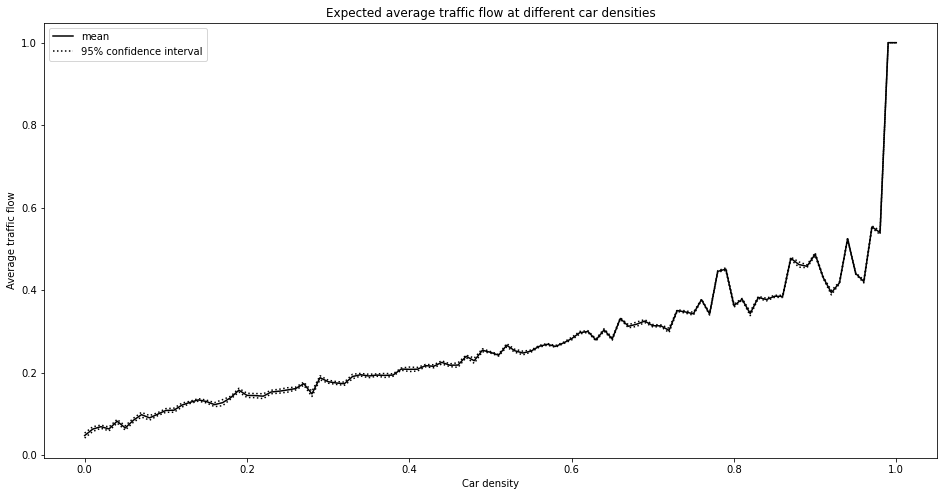

In [472]:
import matplotlib.pyplot as plt
import scipy.stats as sts

plt.figure(figsize=(16, 8))
plt.title('Expected average traffic flow at different car densities')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()

In [473]:
trials = 50 # Number of times to repeat the simulation at each density
prob_slows = np.linspace(0, 1, 101)
average_flows = []  # The results go here

for prob_slow in prob_slows:
    flows = []
    road0 = Road(index = 0, next_s = 7, next_r = 6, road_length = 48, car_density = 1/48, max_speed = 5, prob_slow = prob_slow)
    road1 = Road(index = 1, next_l = 2, next_r = 13, road_length = 48, car_density = 1/48, max_speed = 5, prob_slow = prob_slow)
    road2 = Road(index = 2, next_s = 14, next_l = 5, next_r = 15, road_length = 14, car_density = 7/14, max_speed = 5, prob_slow = prob_slow)
    road3 = Road(index = 3, next_s = 13, next_r = 0, road_length = 14, car_density = 1/14, max_speed = 5, prob_slow = prob_slow)
    road4 = Road(index = 4, next_s = 15, road_length = 48, car_density = 2/48, max_speed = 5, prob_slow = prob_slow)
    road5 = Road(index = 5, next_s = 10, road_length = 48, car_density = 5/48, max_speed = 5, prob_slow = prob_slow)
    road6 = Road(index = 6, next_s = 16, next_l = 10, next_r = 4, road_length = 14, car_density = 6/14, max_speed = 5, prob_slow = prob_slow)
    road7 = Road(index = 7, road_length = 48, car_density = 2/48, max_speed = 5, prob_slow = prob_slow)
    road8 = Road(index = 8, next_s = 1, next_r = 13, next_l = 2, road_length = 48, car_density = 1/48, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road9 = Road(index = 9, next_s = 6, next_r = 1, next_l = 7, road_length = 14, car_density = 5/14, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road10 = Road(index = 10, road_length = 48, car_density = 9/48, max_speed = 5, prob_slow = 0.5)
    road11 = Road(index = 11, next_s = 4, next_l = 16, road_length = 48, car_density = 6/48, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road12 = Road(index = 12, next_s = 2, next_l = 0, road_length = 14, car_density = 6/14, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road13 = Road(index = 13, road_length = 14, car_density = 1/14, max_speed = 5, prob_slow = prob_slow)
    road14 = Road(index = 14, road_length = 14, car_density = 1/14, max_speed = 5, prob_slow = prob_slow)
    road15 = Road(index = 15, road_length = 48, car_density = 9/48, max_speed = 5, prob_slow = prob_slow)
    road16 = Road(index = 16, road_length = 14, car_density = 7/14, max_speed = 5, prob_slow = prob_slow)

    roads = [road0, road1, road2, road3, road4, road5, road6, road7, road8, road9, road10, road11, road12, road13, road14,
        road15, road16]
    for trial in range(trials):
        sim = Simulation(roads, traffic_lights, road_intersection, global_time_step = 500, tflist = tf_list)
        sim.update()
        # Record the final average traffic flow
        flows.append(sim.system.get_average_flow())
    average_flows.append(flows)
average_flows = np.array(average_flows)

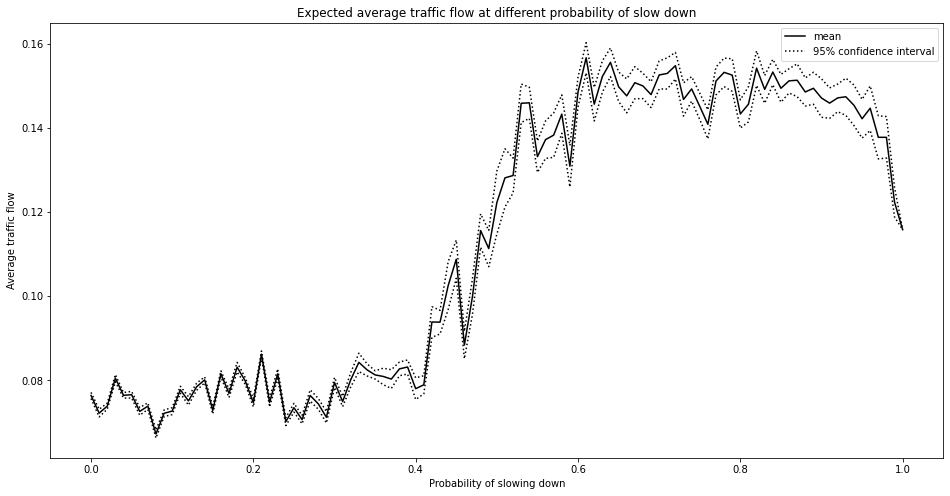

In [475]:
plt.figure(figsize=(16, 8))
plt.title('Expected average traffic flow at different probability of slow down')
plt.xlabel('Probability of slowing down')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()

In [533]:
trials = 50 # Number of times to repeat the simulation at each density
prob_slows = np.linspace(0, 1, 101)
average_flows3 = []  # The results go here

for prob_slow in prob_slows:
    flows = []
    road0 = Road(index = 0, turn_prob = (0.5, 0, 0.5), tl = 0, next_s = 7, next_r = 6, road_length = 48, 
                 car_density = 1/48, max_speed = 5, prob_slow = prob_slow)
    road1 = Road(index = 1, turn_prob = (0, 0.5, 0.5), tl = 4, next_l = 2, next_r = 13, road_length = 48, 
                 car_density = 1/48, max_speed = 5, prob_slow = prob_slow)
    road2 = Road(index = 2, turn_prob = (1/3, 1/3, 1/3), tl = 7, next_s = 14, next_l = 5, next_r = 15, 
                 road_length = 14, car_density = 7/14, max_speed = 5, prob_slow = prob_slow)
    road3 = Road(index = 3, turn_prob = (0.5, 0, 0.5), tl = 4, next_s = 13, next_r = 0, road_length = 14, 
                 car_density = 1/14, max_speed = 5, prob_slow = prob_slow)
    road4 = Road(index = 4, turn_prob = (1, 0, 0), tl = 6, next_s = 15, road_length = 48, car_density = 2/48, 
                 max_speed = 5, prob_slow = prob_slow)
    road5 = Road(index = 5, turn_prob = (1, 0, 0), tl = 2, next_s = 10, road_length = 48, car_density = 5/48, 
                 max_speed = 5, prob_slow = prob_slow)
    road6 = Road(index = 6, turn_prob = (1/3, 1/3, 1/3), tl = 3, next_s = 16, next_l = 10, next_r = 4, road_length = 14, 
                 car_density = 6/14, max_speed = 5, prob_slow = prob_slow)
    road7 = Road(index = 7, road_length = 48, car_density = 2/48, max_speed = 5, prob_slow = prob_slow)
    road8 = Road(index = 8, turn_prob = (1/3, 1/3, 1/3), tl = 0, next_s = 1, next_r = 13, next_l = 2, road_length = 48, 
                 car_density = 1/48, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road9 = Road(index = 9, turn_prob = (1/3, 1/3, 1/3), tl = 1, next_s = 6, next_r = 1, next_l = 7, road_length = 14, 
                 car_density = 5/14, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road10 = Road(index = 10, road_length = 48, car_density = 9/48, max_speed = 5, prob_slow = prob_slow)
    road11 = Road(index = 11, turn_prob = (0.5, 0.5, 0), tl = 2, next_s = 4, next_l = 16, road_length = 48, 
                  car_density = 6/48, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road12 = Road(index = 12, turn_prob = (0.5, 0.5, 0), tl = 4, next_s = 2, next_l = 0, road_length = 14, 
                  car_density = 6/14, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road13 = Road(index = 13, road_length = 14, car_density = 1/14, max_speed = 5, prob_slow = prob_slow)
    road14 = Road(index = 14, road_length = 14, car_density = 1/14, max_speed = 5, prob_slow = prob_slow)
    road15 = Road(index = 15, road_length = 48, car_density = 9/48, max_speed = 5, prob_slow = prob_slow)
    road16 = Road(index = 16, road_length = 14, car_density = 7/14, max_speed = 5, prob_slow = prob_slow)
    
    roads = [road0, road1, road2, road3, road4, road5, road6, road7, road8, road9, road10, road11, road12, road13, road14,
        road15, road16]
    for trial in range(trials):
        sim = Simulation(roads, traffic_lights, road_intersection, global_time_step = 500, tflist = tf_list)
        sim.update_new()
        # Record the final average traffic flow
        flows.append(sim.system.get_average_flow())
    average_flows3.append(flows)
average_flows3 = np.array(average_flows3)

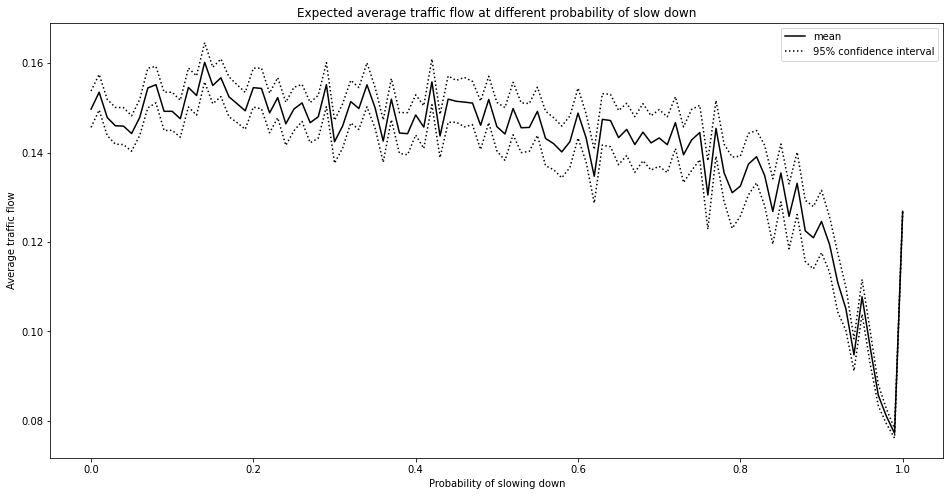

In [534]:
plt.figure(figsize=(16, 8))
plt.title('Expected average traffic flow at different probability of slow down')
plt.xlabel('Probability of slowing down')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows3, axis=1)
std_err = sts.sem(average_flows3, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()

In [531]:
# Run the simulation 200 times at various traffic densities from 0 to 1 and
# record the results. The maximum speed is 5 and the probability of slowing
# down is 0.5.

trials = 50 # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 101)
prob_slow = 0.5
average_flows4 = []  # The results go here

for car_density in densities:
    flows = []
    road0 = Road(index = 0, turn_prob = (0.5, 0, 0.5), tl = 0, next_s = 7, next_r = 6, road_length = 48, 
                 car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road1 = Road(index = 1, turn_prob = (0, 0.5, 0.5), tl = 4, next_l = 2, next_r = 13, road_length = 48, 
                 car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road2 = Road(index = 2, turn_prob = (1/3, 1/3, 1/3), tl = 7, next_s = 14, next_l = 5, next_r = 15, 
                 road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road3 = Road(index = 3, turn_prob = (0.5, 0, 0.5), tl = 4, next_s = 13, next_r = 0, road_length = 14, 
                 car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road4 = Road(index = 4, turn_prob = (1, 0, 0), tl = 6, next_s = 15, road_length = 48, car_density = car_density, 
                 max_speed = 5, prob_slow = prob_slow)
    road5 = Road(index = 5, turn_prob = (1, 0, 0), tl = 2, next_s = 10, road_length = 48, car_density = car_density, 
                 max_speed = 5, prob_slow = prob_slow)
    road6 = Road(index = 6, turn_prob = (1/3, 1/3, 1/3), tl = 3, next_s = 16, next_l = 10, next_r = 4, road_length = 14, 
                 car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road7 = Road(index = 7, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road8 = Road(index = 8, turn_prob = (1/3, 1/3, 1/3), tl = 0, next_s = 1, next_r = 13, next_l = 2, road_length = 48, 
                 car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road9 = Road(index = 9, turn_prob = (1/3, 1/3, 1/3), tl = 1, next_s = 6, next_r = 1, next_l = 7, road_length = 14, 
                 car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road10 = Road(index = 10, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road11 = Road(index = 11, turn_prob = (0.5, 0.5, 0), tl = 2, next_s = 4, next_l = 16, road_length = 48, 
                  car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road12 = Road(index = 12, turn_prob = (0.5, 0.5, 0), tl = 4, next_s = 2, next_l = 0, road_length = 14, 
                  car_density = car_density, max_speed = 5, prob_slow = prob_slow, arrival_distribution = sts.norm(5,0.2))
    road13 = Road(index = 13, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road14 = Road(index = 14, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road15 = Road(index = 15, road_length = 48, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    road16 = Road(index = 16, road_length = 14, car_density = car_density, max_speed = 5, prob_slow = prob_slow)
    
    roads = [road0, road1, road2, road3, road4, road5, road6, road7, road8, road9, road10, road11, road12, road13, road14,
        road15, road16]
    for trial in range(trials):
        sim = Simulation(roads, traffic_lights, road_intersection, global_time_step = 500, tflist = tf_list)
        sim.update_new()
        # Record the final average traffic flow
        flows.append(sim.system.get_average_flow())
    average_flows4.append(flows)
average_flows4 = np.array(average_flows4)

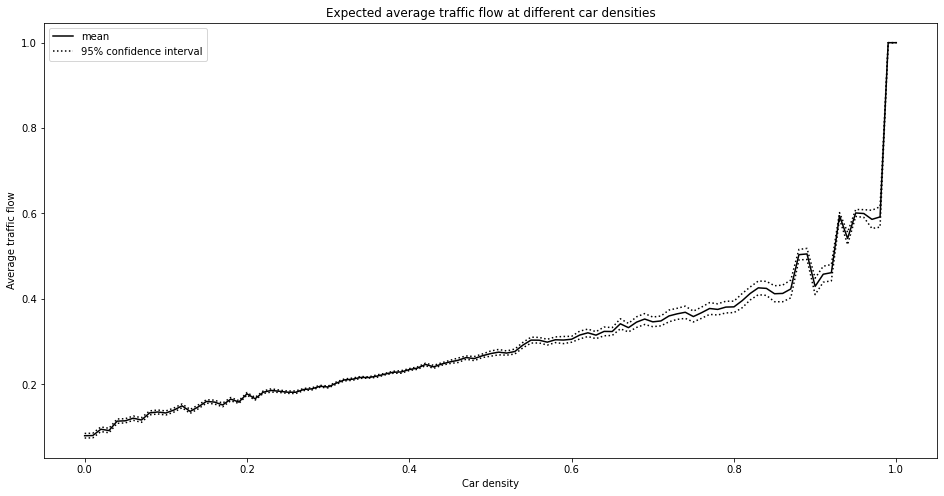

In [535]:
plt.figure(figsize=(16, 8))
plt.title('Expected average traffic flow at different car densities')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows4, axis=1)
std_err = sts.sem(average_flows4, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()